In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('BBBP.csv')
toxdata = toxdata
toxdata.head()
toxdata['p_np'].unique()

array([1, 0])

In [2]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
try:
    raw_features = pd.read_pickle('raw_features.pb')
except FileNotFoundError as e:
    raw_features = calc.pandas(valid_mols, nproc=8)
    raw_features.to_pickle('raw_features.pb')

In [14]:
labels = toxdata[valid_mol_idx].p_np
len(labels)

2039

In [4]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

AUC 0.914832285115304


<Figure size 1200x900 with 0 Axes>

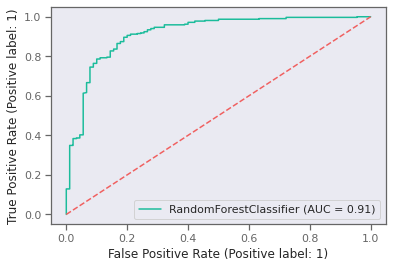

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print('AUC', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
plt.figure(figsize=(4,3), dpi=300)
plot_roc_curve(clf, X_test, y_test)
plt.plot([0,1],[0,1], linestyle='--')
plt.savefig('RF-ROC.png')

In [6]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    raw_features = calc.pandas(molecules, nproc=8, quiet=True)
    features = feature_convert(raw_features)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
    #return np.random.choice([True, False], size=labels.shape)
labels = model_eval(toxdata.iloc[valid_mol_idx].smiles.values[:100])

In [7]:
example_neg = toxdata.iloc[valid_mol_idx].smiles.values[np.argmin(labels)]
example_pos = toxdata.iloc[valid_mol_idx].smiles.values[np.argmax(labels)]
example_neg_y, example_pos_y = model_eval([example_neg, example_pos])
print('neg:', example_neg, '\npos:', example_pos)
print(example_neg_y, example_pos_y)

neg: Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O 
pos: [Cl].CC(C)NCC(O)COc1cccc2ccccc12
0 1


In [8]:
space = exmol.sample_space(example_neg, model_eval)

🤘Done🤘: 100%|██████████| 2705.0/2705 [00:13<00:00, 205.31it/s]              


In [9]:
space_tstats, beta = exmol.lime_explain(space, descriptor_type='MACCS')

array([-1.34646424e+02, -3.80395743e+02,  9.75221266e+01,  1.58299387e+02,
        1.59066171e+02, -9.44296758e+01,  2.65547669e+02,  4.40814142e+02,
       -1.74046720e-01,  2.12076237e+02, -2.42361413e+01, -8.97307525e-02,
        6.04719907e+00,  3.44961394e-02,  1.12029599e-01, -1.81237980e-01,
       -1.74692218e-02, -7.14428742e-02, -1.18448901e+02, -6.34507079e-02,
        4.01051017e+02,  7.24275525e-02, -9.67135469e-02, -6.84816785e-02,
       -1.97959360e-01,  3.04197621e+02, -9.84034450e-02,  7.17645838e-02,
       -6.27322379e-02, -1.42532474e-01, -2.57557734e-01, -1.63100280e-01,
       -1.28819147e-01,  1.29245055e-01,  3.30579697e-02, -6.32843354e+01,
       -3.70529196e-02, -5.37511188e-02,  8.39459871e-02, -1.29623973e+00,
       -1.08942599e-01, -1.88287254e-01, -3.75590799e-03, -6.11270369e-02,
        1.02404654e+02, -9.49483599e-02, -9.22482151e-03, -4.22641062e-02,
        9.92069879e-01, -1.74571343e-01, -1.66278678e-02, -2.52699935e-02,
       -1.67617581e-01, -

In [11]:
from collections import OrderedDict
feature_importance = {a:b for a, b in zip(space[0].descriptors.descriptor_names, space_tstats)}
feature_importance = dict(sorted(feature_importance.items(),
             key=lambda item: abs(item[1]),
             reverse=True))
#Fitted space important features
feature_importance

{'Is it an atom in a ring?': 5.806132321330973,
 'Are there more than 2 methyl groups?': -5.456485727531511,
 'Are there more than 3 oxygen atoms?': -4.342549023467059,
 'Are there two heteroatoms bonded to each other?': -4.160042025171137,
 'Are there two methylene carbons bonded by a single bond? Or are there two atoms separated by two methylene carbons?': 2.9584579145800327,
 'Are there multiple heteroatoms bonded to at least one hydrogen neighbor?': 2.6443422721034526,
 'Is there a heterocycle?': -2.634299030758128,
 'Is there a nitrogen binded to at least one hydrogen?': -2.462684558882787,
 'Are there multiple heteroatoms bonded to at least one heteroatom neighbor?': 2.3478695660942095,
 'Is there more than one oxygen atom?': 2.2732717176605926,
 'Is there an amine group?': -2.2407689135588424,
 'Is there a halogen at a chain/ring boundary?': 2.204493638173144,
 'Is there a 5M ring?': -2.1048280968327355,
 'Is there an atom bonded to another atom by a ring bond and bonded to a ox

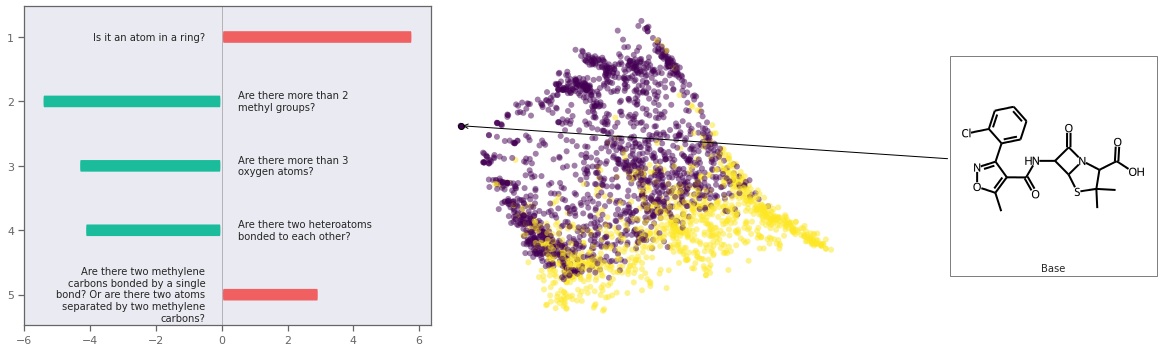

In [13]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

fig = plt.figure(figsize=(12,5))
# ax_dict = fig.subplot_mosaic('BBBAA')
ax_dict = fig.subplot_mosaic('AAABBB')

r = Rectangle((0, 0), 1, 1)
# cmap = plt.get_cmap("gist_rainbow", 20)
# colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

t = list(feature_importance.values())[:5]
colors = []
for ti in t:
    if ti < 0:
        colors.append(color_cycle[0])
    if ti > 0:
        colors.append(color_cycle[1])

keys = list(feature_importance.keys())[:5]

bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
new_patches = []
for patch in reversed(ax_dict['A'].patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.040,rounding_size=0.015",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax_dict['A'].add_patch(patch)

count = 1
for rect, ti, k in zip(bar1, t, keys):
    y = rect.get_y() + rect.get_height()/2.
    if len(k) > 60:
        k = textwrap.fill(k, 30)
    elif len(k) > 30:
        k = textwrap.fill(k, 25)
    if ti < 0:
        x = 0.5
        ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
        count+=1
    else:
        x = -0.5
        ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
        count+=1
    
    
ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
ax_dict['A'].invert_yaxis()
# ax_dict['A'].get_yaxis().set_ticks([])
exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B'])
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rf-feature.png', dpi=180, bbox_inches='tight')#, dpi=180)

In [16]:
exps = exmol.rcf_explain(space, nmols=5)
print(exps, len(exps))

[Example(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O', selfies='[C][C][O][N][=C][Branch1_1][Branch2_3][C][=C][C][=C][C][=C][Ring1][Branch1_2][Cl][C][Expl=Ring1][N][C][Branch1_2][C][=O][N][C][C][Branch1_2][C][=O][N][C][Ring1][Branch1_1][S][C][Branch1_1][C][C][Branch1_1][C][C][C][Ring1][Branch1_3][C][Branch1_2][C][=O][O]', similarity=1.0, yhat=0, index=0, position=array([-9.93031437,  2.50801575]), is_origin=True, cluster=-1, label=None, descriptors=Descriptors(descriptors=(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0), de

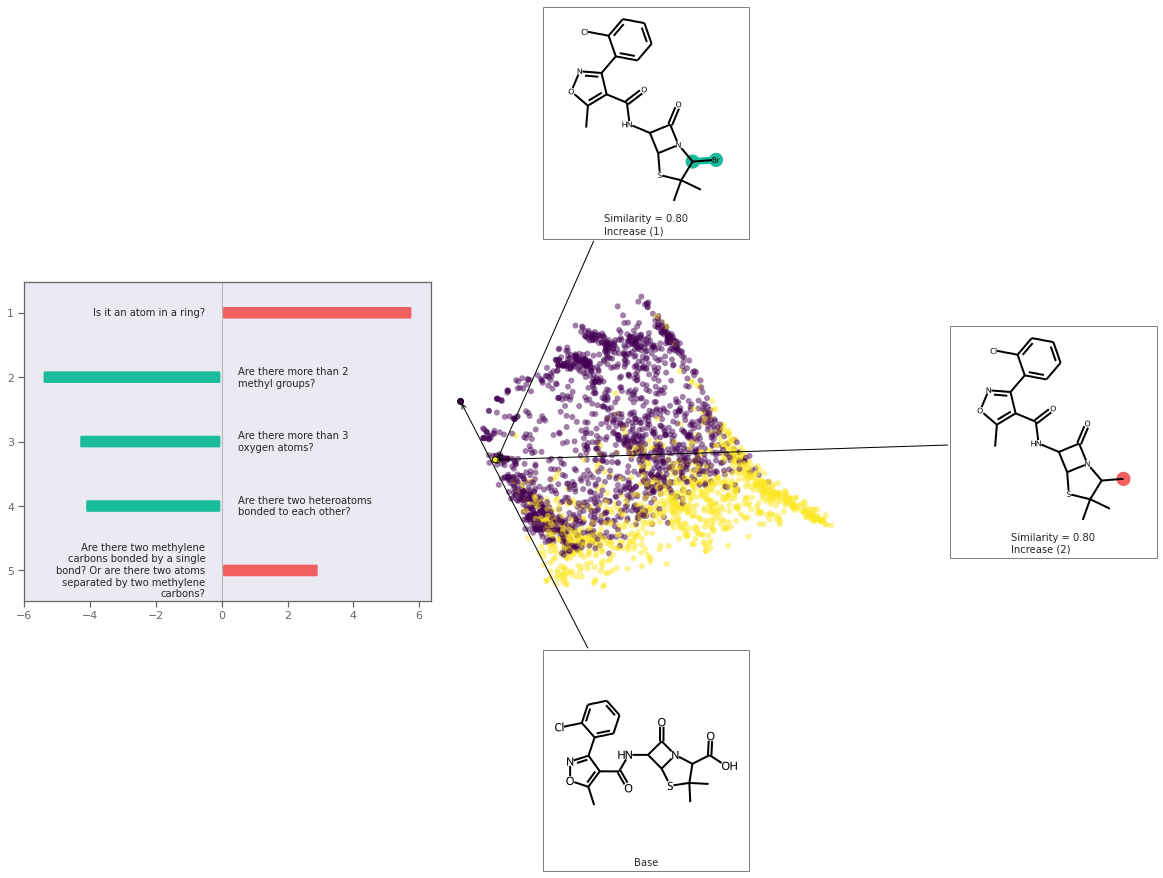

In [18]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

fig = plt.figure(figsize=(12,5))

ax_dict = fig.subplot_mosaic('AAABBB')

r = Rectangle((0, 0), 1, 1)

t = list(feature_importance.values())[:5]
colors = []
for ti in t:
    if ti < 0:
        colors.append(color_cycle[0])
    if ti > 0:
        colors.append(color_cycle[1])

keys = list(feature_importance.keys())[:5]

bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
new_patches = []
for patch in reversed(ax_dict['A'].patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.040,rounding_size=0.015",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax_dict['A'].add_patch(patch)

count = 1
for rect, ti, k in zip(bar1, t, keys):
    y = rect.get_y() + rect.get_height()/2.
    if len(k) > 60:
        k = textwrap.fill(k, 30)
    elif len(k) > 30:
        k = textwrap.fill(k, 25)
    if ti < 0:
        x = 0.5
        ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
        count+=1
    else:
        x = -0.5
        ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
        count+=1
    
    
ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
ax_dict['A'].invert_yaxis()
exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B'], plot_descriptors = True)
plt.tight_layout()
plt.savefig('rf-feature.png', dpi=180, bbox_inches='tight')#, dpi=180)

In [12]:
t_stats = exmol.lime_explain(exps)
t_stats

array([0.04069388, 0.20687185, 0.27214578, 0.14697905, 0.32228409,
       0.02708995, 0.18915174, 0.06257426, 0.09786646, 0.3222839 ])

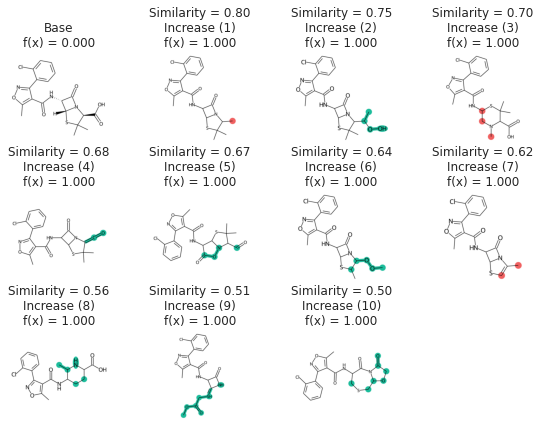

In [13]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=3)
plt.savefig('rf-simple.png', dpi=180)

## Schematic Plots

In [11]:
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem.Draw import MolToImage as mol2img
dos = rdkit.Chem.Draw.MolDrawOptions()
dos.useBWAtomPalette()
#dos.minFontSize = fontsize
img = mol2img(smi2mol(exps[0].smiles), options=dos)
img.save('rf-schem-1.png')

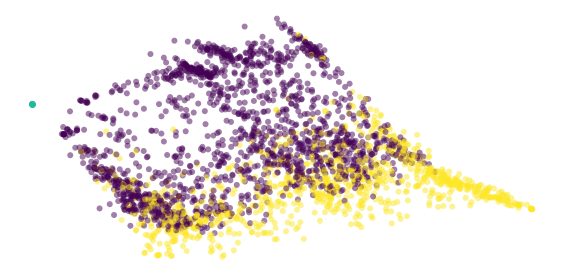

In [12]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, [], figure_kwargs=fkw, mol_size=(300,200), offset=1)
plt.scatter(exps[0].position[0], exps[0].position[1])
plt.tight_layout()
plt.savefig('rf-schem-2.png', bbox_inches='tight', dpi=180)

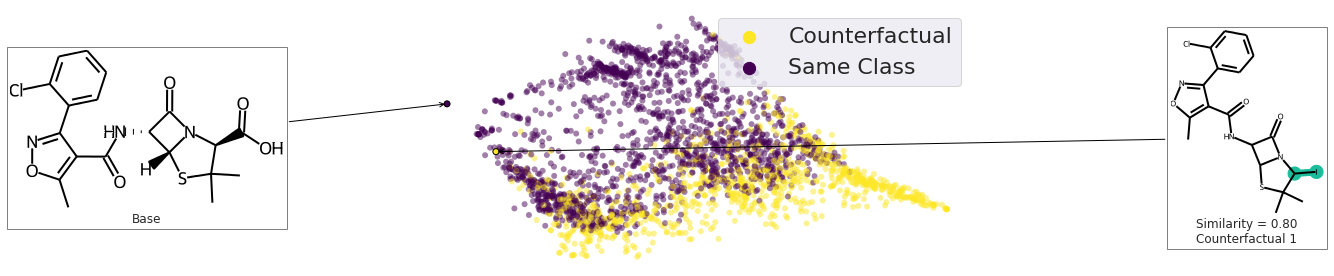

In [13]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, exps[:2], figure_kwargs=fkw, mol_size=(300,200), offset=0)
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Same Class', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('rf-schem-3.png', bbox_inches='tight', dpi=180)

## Chemed

In [14]:
cspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', model_eval)
zspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', model_eval, num_samples=500, preset='chemed')

🤘Done🤘: 100%|██████████| 2767.0/2767 [00:25<00:00, 107.12it/s]                  
🤘Done🤘: 100%|██████████| 147.0/147 [00:00<00:00, 856.80it/s]                    


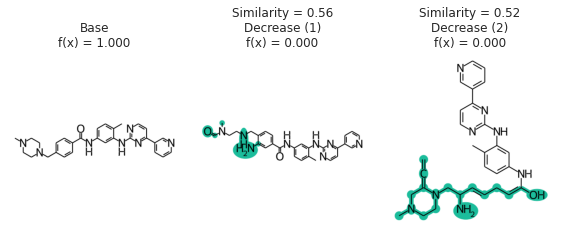

In [15]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exmol.rcf_explain(cspace, nmols=4), figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('gleevac-cs.png', bbox_inches='tight', dpi=180)

[Example(smiles='Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', selfies='[C][C][=C][C][=C][Branch2_1][Ring1][Branch2_1][C][=C][Ring1][Branch1_2][N][C][=N][C][=C][C][Branch1_2][Ring2][=N][Ring1][Branch1_2][C][=C][C][=C][N][=C][Ring1][Branch1_2][N][C][Branch1_2][C][=O][C][=C][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][C][N][C][C][N][Branch1_1][Branch1_1][C][C][Ring1][Branch1_2][C]', similarity=1.0, yhat=1, index=0, position=array([-1.18271771,  0.9320159 ]), is_origin=True, cluster=-1, label=None), Example(smiles='CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN(CCO)C(=O)CN(C)C)NC3=NC=CC(=N3)C4=CN=CC=C4', selfies='[C][C][=C][Branch2_1][Ring2][Branch2_2][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][N][C][Branch1_2][C][=O][C][=C][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][C][N][Branch1_1][Ring2][C][C][O][C][Branch1_2][C][=O][C][N][Branch1_1][C][C][C][N][C][=N][C][=C][C][Branch1_2][Ring2][=N][Ring1][Branch1_2][C][=C][N][=C][C][=C][Ring1][Branch1_2]', similar

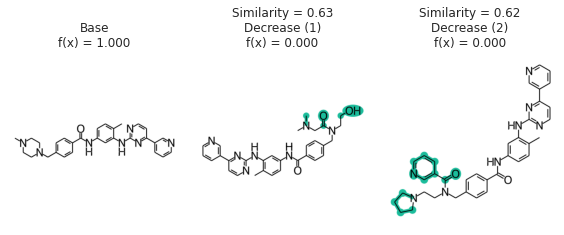

In [17]:
exps = exmol.rcf_explain(zspace, nmols=5)
# fix ionization
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
print(exps, len(exps))
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('gleevac-c.png', bbox_inches='tight', dpi=180)

# Effect of backtrack